In [1]:
from __future__ import print_function
#
import os
import glob
import re
import argparse
import pandas as pd
import numpy as np
import subprocess
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm # if use notebook
# from tqdm import tqdm, trange

from threading import Thread, Event
import queue

from PIL import Image
import cv2
import imgaug as ia
from imgaug import augmenters as iaa


import random

#from general_function_handler import op_img, call_generator
#from model import create_graph, losses, evaluation, trainning
#import model_2

parser = argparse.ArgumentParser()
parser.add_argument('--gpu_id', default=0)
parser.add_argument('--image_dir', default="dataset")
parser.add_argument('--save_dir', default='./result')
parser.add_argument('--is_training', default=1, type=int)
parser.add_argument('--batch_size', default=16, type=int)
parser.add_argument('--do_augment', default=True, type = bool)
parser.add_argument('--epochs', default=50, type=int)
parser.add_argument('--lr', default=0.0001, type=float)
parser.add_argument('--image_size', default=(120,120,3), type = int)
parser.add_argument('--n_classes', default=2, type = int)
parser.add_argument('--train_ratio', default=0.9, type = float)
parser.add_argument('--use_model_ckpt', default = None, type = str)
FLAGS = parser.parse_args([])
print(FLAGS)

Namespace(batch_size=16, do_augment=True, epochs=50, gpu_id=0, image_dir='dataset', image_size=(120, 120, 3), is_training=1, lr=0.0001, n_classes=2, save_dir='./result', train_ratio=0.9, use_model_ckpt=None)


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(FLAGS.gpu_id)
import tensorflow as tf

if not os.path.exists(FLAGS.save_dir):
    os.makedirs(FLAGS.save_dir)

model_graph_name = FLAGS.save_dir + '/model.ckpt'
    
graphs_dir = FLAGS.save_dir + '/graphs'
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)

"""  Get data """
d_train = FLAGS.image_dir + '/train/'
d_test = FLAGS.image_dir + '/test1/'

image_train_list = glob.glob(d_train + '*.jpg')
image_test_list = glob.glob(d_test + '*.jpg')

df_train = pd.DataFrame({'img_path': image_train_list})
df_test = pd.DataFrame({'img_path': image_test_list})

df_train['cate'] = df_train.img_path.apply(os.path.basename)
df_train['cate'] = [i.split(".")[0] for i in list(df_train.cate)]
df_train.cate = df_train.cate.replace({'dog': 0, 'cat': 1})

nb_epoch = FLAGS.epochs

df_train_0, df_val_0 = train_test_split(df_train[df_train['cate'] == 0], test_size = 1-FLAGS.train_ratio)
df_train_1, df_val_1 = train_test_split(df_train[df_train['cate'] == 1], test_size = 1-FLAGS.train_ratio)

df_val = pd.concat((df_val_0, df_val_1)).reset_index(drop = True)

del df_val_0, df_val_1

In [3]:
df_train.head()

,img_path,cate
0,dataset/train\cat.0.jpg,1
1,dataset/train\cat.1.jpg,1
2,dataset/train\cat.10.jpg,1
3,dataset/train\cat.100.jpg,1
4,dataset/train\cat.1000.jpg,1


In [4]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    #iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    sometimes(iaa.Affine(
            scale = (0.8,1.2),
            translate_percent = (-0.2, 0.2),
            rotate = (-30, 30),
            order = [0, 1],
            #cval = (0,255),
            mode = 'wrap'
            ))
])

def cv_load_and_resize(x, is_training = True):
    im_w, im_h, im_c = FLAGS.image_size
    im = cv2.imread(x)
    im = cv2.resize(im, (im_w, im_h))
    if FLAGS.do_augment and is_training:
        im = seq.augment_image(im)
    return im
    
def get_evalute(dt):
    images = np.array([cv_load_and_resize(i, is_training = False) for i in dt.img_path], dtype=np.float32) # don't do augmentation!
    
    """ do preprocessing here"""
    ## If use resnet or other transfer learning
    """ """
    y_out = np.array(dt['cate'])
    y_out = tf.keras.utils.to_categorical(y_out, num_classes=FLAGS.n_classes)
    return images, y_out

In [5]:
def get_train_idx(bz, idp_len_list):
    """ Description 
    Input:
    bz: batch size
    idp_len_list: independent length list 
    
    Output:
    yield index list
    """
    bz_per_class = bz // len(idp_len_list) # To know how many samples should be get for each class
    batch_num = [x // bz_per_class for x in idp_len_list]
    batch_nth = [0] * len(idp_len_list)
    
    select = [list(range(x)) for x in idp_len_list]
    
    for s in select:
        random.shuffle(s)
    
    while True:
        idxs = []
        for i in range(len(idp_len_list)):
            if batch_nth[i] >= batch_num[i]:
                batch_nth[i] = 0
                random.shuffle(select[i])
            idx = select[i][batch_nth[i] * bz_per_class: (batch_nth[i] + 1) * bz_per_class]
            batch_nth[i] += 1
            idxs.append(idx)
        yield idxs
    
def get_train_data(queue, df_list):
    while True:
        idxs = queue.get()
        
        select_list = []
        
        for df, idx in zip(df_list, idxs):
            select_list.append(df.iloc[idx])
        select_list = pd.concat(select_list)
        #print(select_list)
        images = np.array([cv_load_and_resize(iid) for iid in select_list.img_path], dtype=np.float32)
        images = images.astype(np.float32)
        """ do preprocessing here"""
        ## If use resnet or other transfer learning
        
        """ Y out """
        y_out = np.array(select_list['cate'])
        y_out = tf.keras.utils.to_categorical(y_out, FLAGS.n_classes)
        
        yield images, y_out

        
def enqueue(queue, stop, gen_func, args):
    gen = gen_func(*args)
    while True:
        if stop.is_set():
            return
        queue.put(next(gen))

In [6]:
train_queue = queue.Queue(maxsize=5)
train_idx_queue = queue.Queue(maxsize=50)

### to stop threads after training
events = []

### enqueue training index 
event = Event()
thread = Thread(target=enqueue, 
                args= (train_idx_queue, 
                       event, 
                       get_train_idx, 
                       (FLAGS.batch_size, [len(df_train_0), len(df_train_1)])
                                      ))
thread.start()
events.append(event)

### enqueue train batch
for i in range(6):
    event = Event()
    thread = Thread(target=enqueue, 
                    args = (train_queue,
                            event, 
                            get_train_data, 
                            (train_idx_queue, [df_train_0, df_train_1])
                   ))
    thread.start()
    events.append(event)

a,b = train_queue.get()

In [7]:
x_val, y_val = get_evalute(df_val)
print(x_val.shape)
print(a.shape, b.shape)

(2500, 120, 120, 3)
(16, 120, 120, 3) (16, 2)


In [8]:
im_w, im_h, im_c = FLAGS.image_size
drp_holder = tf.placeholder(tf.float32)

a_in = tf.keras.layers.Input(shape = (im_w, im_h, im_c))
x = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=32, activation=tf.nn.selu)(a_in)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=32, activation=tf.nn.selu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, activation=tf.nn.selu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(units=64, activation=tf.nn.selu)(x)
x = tf.keras.layers.Dropout(drp_holder)(x)

x = tf.keras.layers.Dense(units=32, activation=tf.nn.selu)(x)
x = tf.keras.layers.Dropout(drp_holder)(x)

out = tf.keras.layers.Dense(units=FLAGS.n_classes, activation='linear')(x) # softmax will be at loss part

y_holder = tf.placeholder(tf.float32, shape=[None, FLAGS.n_classes])
total_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_holder, logits=out))


optim = tf.train.AdamOptimizer(learning_rate=FLAGS.lr)
optim_op = optim.minimize(total_loss)

correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y_holder, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
#n_batch = len(df_train) // FLAGS.batch_size + 1 # standard way - look all samples per epoch
n_batch = 200 # evaluate per 200 steps

# -------------------------- #
global_train_loss, global_train_acc = [], []
global_valid_loss, global_valid_acc = [], []

with tf.Session() as sess:
    
    sess.run([tf.global_variables_initializer()])
    
    epoch_bar = tqdm(range(FLAGS.epochs), 
                     desc = "Train epoch", 
                     unit = "Epoch")
    for i in epoch_bar:
        if i == 0:
            epoch_bar.set_description("Training loss/acc: %.2f/%.2f ;Validation: %.2f/%.2f" % 
                                  (0.0,0.0,0.0,0.0))
        else:
            epoch_bar.set_description("Training loss/acc: %.2f/%.2f ;Validation: %.2f/%.2f" % 
                                  (global_train_loss[-1], global_train_acc[-1], global_valid_loss[-1], global_valid_acc[-1]))
        
        train_epoch_loss, train_epoch_acc = [], []
        train_batch_bar = tqdm(range(n_batch), 
                               desc = "Training batch", 
                               unit = "batch", 
                               leave = False)
        for j in train_batch_bar:
            x_, y_ = train_queue.get()
            
            batch_loss, batch_acc, _ = sess.run([total_loss, accuracy_op, optim_op], 
                                                feed_dict = {a_in: x_, 
                                                                     y_holder: y_, 
                                                                     tf.keras.backend.learning_phase(): 1,
                                                                     drp_holder: 0.2})
            train_epoch_loss.append(batch_loss)
            train_epoch_acc.append(batch_acc)
            current_train_loss = np.mean(train_epoch_loss)
            current_train_acc = np.mean(train_epoch_acc)
            train_batch_bar.set_description('Training loss / acc: %.2f/%.2f' % (current_train_loss, current_train_acc))    
        
        global_train_loss.append(current_train_loss)
        global_train_acc.append(current_train_acc)
        
        valid_epoch_loss, valid_epoch_acc = [], []
        valid_batch_bar = tqdm(range(len(df_val) // FLAGS.batch_size + 1), 
                               desc = "Valid batch", 
                               unit = "batch", leave = False)
        for j in valid_batch_bar:
            this_val_loss, this_val_acc = sess.run([total_loss, accuracy_op], 
                                                       feed_dict = {a_in: x_val[j*FLAGS.batch_size : (j+1) * FLAGS.batch_size], 
                                                                            y_holder: y_val[j*FLAGS.batch_size : (j+1) * FLAGS.batch_size],
                                                                            tf.keras.backend.learning_phase(): 0,
                                                                            drp_holder: 0.0} )
            valid_epoch_loss.append(this_val_loss)
            valid_epoch_acc.append(this_val_acc)
            valid_batch_bar.set_description('Validation loss / acc: %.2f/%.2f' % (this_val_loss, this_val_acc))
        
        current_valid_loss = np.mean(valid_epoch_loss)
        current_valid_acc = np.mean(valid_epoch_acc)
        
        # 
        global_valid_loss.append(current_valid_loss)
        global_valid_acc.append(current_valid_acc)
                

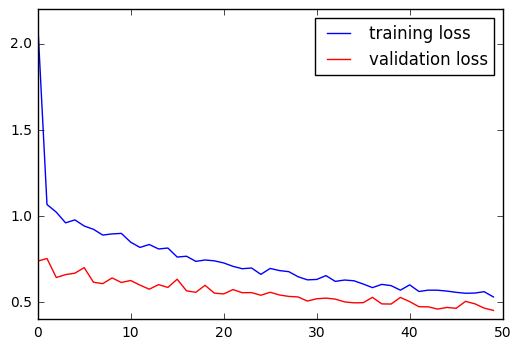

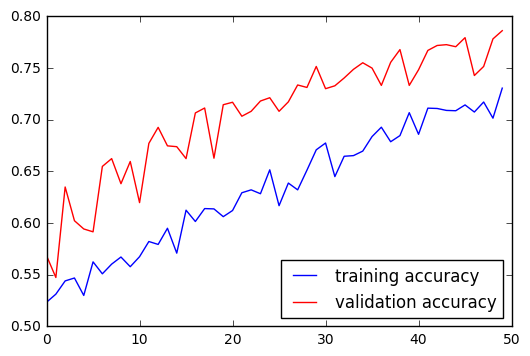

In [10]:
plt.plot(range(len(global_train_loss)), global_train_loss, 'b', label = 'training loss')
plt.plot(range(len(global_valid_loss)), global_valid_loss, 'r', label = 'validation loss')
plt.legend()
plt.show()

plt.plot(range(len(global_train_acc)), global_train_acc, 'b', label = 'training accuracy')
plt.plot(range(len(global_valid_acc)), global_valid_acc, 'r', label = 'validation accuracy')
plt.legend(loc = 4)
plt.show()

In [ ]:
# no drp
#Training loss/acc: 0.48/0.77 ;Validation: 0.43/0.80: 100% 50/50 [13:22<00:00, 16.04s/Epoch]

# with drp = 0.1
#Training loss/acc: 0.53/0.74 ;Validation: 0.48/0.76: 100% 50/50 [13:27<00:00, 16.14s/Epoch]

# with drp = 0.2
#Training loss/acc: 0.56/0.70 ;Validation: 0.47/0.78: 100% 50/50 [13:38<00:00, 16.38s/Epoch]